## Import packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
from matplotlib.patches import Ellipse
from mpl_toolkits.basemap import Basemap
import os
os.chdir('../pygiop/')
import pandas as pd
from scripts import pwIOP, phytoA, getChlor, getGiop

In [2]:
DATA_FOLDER = '/Users/erickson/Documents/Postdoc/Research/Bayes_GIOP/Valente_dataset/'

## Load data

In [3]:
fn_rrs = DATA_FOLDER+'insitudb_rrs_satbands6.csv'
db_rrs = pd.read_csv(fn_rrs)
fn_iop = DATA_FOLDER+'insitudb_iopskdtsm_satbands6_2019-06_corrected.csv'
db_iop = pd.read_csv(fn_iop)
fn_chl = DATA_FOLDER+'insitudb_chla.csv'
db_chl = pd.read_csv(fn_chl)

/Users/erickson/.conda/envs/zke/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (354,355,356) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# print names of columns
for col in db_rrs.columns:
    print(col,end=', ')

idx, time, lat, lon, rrs_MER1, lam_MER1, rrs_MER2, lam_MER2, rrs_MER3, lam_MER3, rrs_MER4, lam_MER4, rrs_MER5, lam_MER5, rrs_MER6, lam_MER6, rrs_MER7, lam_MER7, rrs_MER8, lam_MER8, rrs_MER9, lam_MER9, rrs_MER10, lam_MER10, rrs_MER11, lam_MER11, rrs_MER12, lam_MER12, rrs_MER13, lam_MER13, rrs_MOD1, lam_MOD1, rrs_MOD2, lam_MOD2, rrs_MOD3, lam_MOD3, rrs_MOD4, lam_MOD4, rrs_MOD5, lam_MOD5, rrs_MOD6, lam_MOD6, rrs_MOD7, lam_MOD7, rrs_MOD8, lam_MOD8, rrs_MOD9, lam_MOD9, rrs_SWS1, lam_SWS1, rrs_SWS2, lam_SWS2, rrs_SWS3, lam_SWS3, rrs_SWS4, lam_SWS4, rrs_SWS5, lam_SWS5, rrs_SWS6, lam_SWS6, rrs_SWS7, lam_SWS7, rrs_SWS8, lam_SWS8, rrs_VIR1, lam_VIR1, rrs_VIR2, lam_VIR2, rrs_VIR3, lam_VIR3, rrs_VIR4, lam_VIR4, rrs_VIR5, lam_VIR5, rrs_OLC1, lam_OLC1, rrs_OLC2, lam_OLC2, rrs_OLC3, lam_OLC3, rrs_OLC4, lam_OLC4, rrs_OLC5, lam_OLC5, rrs_OLC6, lam_OLC6, rrs_OLC7, lam_OLC7, etopo1, rrs_dataset, rrs_subdataset, rrs_contributor, flag_time, 

In [5]:
wvs = np.array([411,443,488,510,555,670]) # this is for SeaWiFS
#wvs = np.array([411,443,488,531,547,667,678,750]) # this is for MODIS

In [6]:
lon = db_iop['lon'].to_numpy()
lat = db_iop['lat'].to_numpy()

### Find indices where all data are present (for SeaWiFS)


In [7]:
good_rrs_inds = np.all(np.array([np.isfinite(db_rrs['rrs_SWS%d'%i]) for i in range(1,7)]),axis=0)
good_aph_inds = np.all(np.array([np.isfinite(db_iop['aph_SWS%d'%i]) for i in range(1,7)]),axis=0)
good_adg_inds = np.all(np.array([np.isfinite(db_iop['adg_SWS%d'%i]) for i in range(1,7)]),axis=0)
good_bbp_inds = np.all(np.array([np.isfinite(db_iop['bbp_SWS%d'%i]) for i in range(1,7)]),axis=0)
good_iop_inds = good_aph_inds & good_adg_inds & good_bbp_inds
good_chl_inds = np.isfinite(db_chl['chla_fluor']) | np.isfinite(db_chl['chla_hplc'])

good_rrs_idx = db_rrs['idx'][good_rrs_inds].to_numpy()
good_iop_idx = db_iop['idx'][good_iop_inds].to_numpy()
good_chl_idx = db_chl['idx'][good_chl_inds].to_numpy()

all_idx = np.intersect1d(np.intersect1d(good_rrs_idx,good_iop_idx),good_chl_idx)
all_inds_rrs = np.where(good_rrs_inds)[0][np.isin(good_rrs_idx,all_idx)]
all_inds_iop = np.where(good_iop_inds)[0][np.isin(good_iop_idx,all_idx)]
all_inds_chl = np.where(good_chl_inds)[0][np.isin(good_chl_idx,all_idx)]

In [10]:
print('Num with all variables',len(all_idx))

Num with all variables 86


In [12]:
print('These are the datasets that had all variables')
print('Rrs datasets:',db_rrs['rrs_dataset'][all_inds_rrs].unique())
print('aph datasets:',db_iop['aph_dataset'][all_inds_iop].unique())
print('adg datasets:',db_iop['adg_dataset'][all_inds_iop].unique())
print('bbp datasets:',db_iop['bbp_dataset'][all_inds_iop].unique())
print('fchl datasets:',db_chl['chla_fluor_dataset'][all_inds_chl].unique())
print('HPLC datasets:',db_chl['chla_hplc_dataset'][all_inds_chl].unique())



These are the datasets that had all variables
Rrs datasets: ['nomad']
aph datasets: ['nomad']
adg datasets: ['nomad']
bbp datasets: ['nomad']
fchl datasets: ['nomad']
HPLC datasets: ['nomad' nan]


In [17]:
all_rrs = np.array([db_rrs['rrs_SWS%d'%i][all_inds_rrs] for i in range(1,7)])
all_aph = np.array([db_iop['aph_SWS%d'%i][all_inds_iop] for i in range(1,7)])
all_adg = np.array([db_iop['adg_SWS%d'%i][all_inds_iop] for i in range(1,7)])
all_bbp = np.array([db_iop['bbp_SWS%d'%i][all_inds_iop] for i in range(1,7)])

all_lon = db_iop['lon'][all_inds_iop].to_numpy()
all_lat = db_iop['lat'][all_inds_iop].to_numpy()

all_chlf = db_chl['chla_fluor'][all_inds_chl].to_numpy()
all_hplc = db_chl['chla_hplc'][all_inds_chl].to_numpy()

all_chl = np.array([db_chl['chla_hplc'][i] if np.isfinite(db_chl['chla_hplc'][i]) else db_chl['chla_fluor'][i] for i in all_inds_chl])

### Plot map

In [168]:
ex_ind = 41 # this is what is used int he example

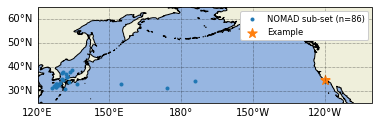

In [386]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([120, 260, 25, 65], crs=ccrs.PlateCarree())
#ax.coastlines()
ax.scatter(all_lon,all_lat,transform=ccrs.PlateCarree(),marker='.',clip_on=False,label='NOMAD sub-set (n=86)')
ax.scatter(all_lon[ex_ind],all_lat[ex_ind],marker='*',s=100,transform=ccrs.PlateCarree(),label='Example')
ax.legend(loc='upper right',fontsize='small',framealpha=1)
gl = ax.gridlines(draw_labels=True,ylocs=np.arange(20,61,10),xlocs=[120,150,180,-150,-120],color='k',linewidth=0.5,linestyle=':')
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')

plt.savefig('NOMAD_map.png',dpi=300)

### Just test HPLC Chl-a vs. Chl-a fluorescence

Num HPLC Chl: 70 out of 86
Num fluorChl: 86 out of 86


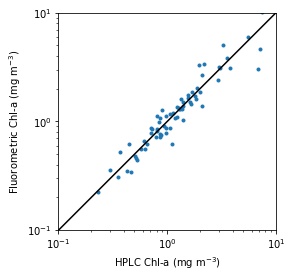

In [18]:
plt.loglog(all_hplc,all_chlf,ls='none',marker='.')
plt.xlim([.1,10])
plt.ylim([.1,10])
plt.gca().set_aspect(1)
plt.plot([0,10],[0,10],c='k')
plt.xlabel('HPLC Chl-a (mg m$^{-3}$)')
plt.ylabel('Fluorometric Chl-a (mg m$^{-3}$)')
print('Num HPLC Chl: %d out of %d'%(np.sum(np.isfinite(all_hplc)),len(all_hplc)))
print('Num fluorChl: %d out of %d'%(np.sum(np.isfinite(all_chlf)),len(all_chlf)))


In [374]:
def get_eta(wvs,bbp):
    try:
        eta = -1*np.polyfit(np.log(wvs),np.log(bbp),1)[0]
    except:
        eta = np.nan
    return eta

def get_sdg(wvs,adg):
    sdg = -np.polyfit(wvs,np.log(adg),1)[0]
    return sdg

def get_aphstar(wv,chl):
    aphstar = phytoA.get_bricaud_aph(chl,wv,1)[3]/0.055
    return aphstar

def get_adgstar(wv,sdg):
    adgstar = np.exp(-sdg*(wv-443))
    return adgstar

def get_bbpstar(wv,eta):
    bbpstar = (443/wv)**eta
    return bbpstar

def get_Rrs(wv,aph,adg,bbp,sdg,eta,chl,g1=0.0949,g2=0.0794):    
    aw = pwIOP.get_aw(wv)
    bbw = pwIOP.get_bbw(wv)
    
    atot = aw + aph*get_aphstar(wv,chl) + adg*get_adgstar(wv,sdg)
    bbtot = bbw + bbp*get_bbpstar(wv,eta)
    
    u = bbtot/(atot + bbtot)
    rrs = g1*u + g2*u**2
    Rrs = 0.52*rrs / (1-1.7*rrs)
    
    return Rrs

In [382]:
all_sdg = np.array([get_sdg(wvs,adg) for adg in all_adg.T])
all_eta = np.array([get_eta(wvs,bbp) for bbp in all_bbp.T])
der_chl = np.array([getChlor.getOC(r1=rrs[1],r2=rrs[2],r3=rrs[3],r4=rrs[4],method='oc4') for rrs in all_rrs.T])
der_rrs = np.array([get_Rrs(wvs,aph,adg,bbp,sdg,eta,chl) for aph,adg,bbp,sdg,eta,chl in zip(all_aph[1],all_adg[1],all_bbp[1],all_sdg,all_eta,der_chl)]).T

In [376]:
all_adg_der = np.array([np.exp(np.polyval(np.polyfit(wvs,np.log(adg),1),wvs)) for adg in all_adg.T]).T
all_bbp_der = np.array([np.exp(np.polyval(np.polyfit(np.log(wvs),np.log(bbp),1),np.log(wvs))) for bbp in all_bbp.T]).T

In [385]:
print('Mean Sdg value: %.5f nm-1'%np.mean(all_sdg))
print(' std Sdg value: %.5f nm-1'%np.std(all_sdg))
print('10th-90th percentile (nm-1): %.5f to %.5f'%tuple(np.percentile(all_sdg,[10,90])))

Mean Sdg value: 0.01311 nm-1
 std Sdg value: 0.00179 nm-1
10th-90th percentile (nm-1): 0.01077 to 0.01565


In [377]:
MAE_all = np.array([((np.exp(np.mean(np.abs(np.log(der/rrs))))-1)*100) for der,rrs in zip(der_rrs.T,all_rrs.T)])


In [335]:
print('%d of %d below 5%% misfit in adg (all wavelengths together)'%(np.sum(np.abs((all_adg_der-all_adg)/all_adg)<.05),all_adg_der.size))
print('%d of %d below 2%% misfit in bbp (all wavelengths together)'%(np.sum(np.abs((all_bbp_der-all_bbp)/all_bbp)<.02),all_bbp_der.size))


450 of 516 below 5% misfit in adg (all wavelengths together)
501 of 516 below 2% misfit in bbp (all wavelengths together)


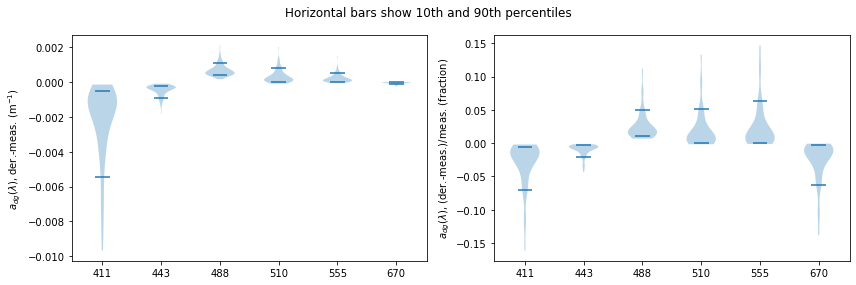

In [387]:
kwargs = {'positions':range(len(wvs)),'showextrema':False,'quantiles':np.tile(np.array([0.10,0.90]),[len(wvs),1]).T}
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.violinplot((all_adg_der-all_adg).T,**kwargs)
plt.xticks(range(6),wvs);
plt.ylabel(r'$a_{dg}(\lambda)$, der.-meas. (m$^{-1}$)')
plt.subplot(122)
plt.violinplot(((all_adg_der-all_adg)/all_adg).T,**kwargs)
plt.xticks(range(6),wvs);
plt.ylabel(r'$a_{dg}(\lambda)$, (der.-meas.)/meas. (fraction)')
plt.suptitle('Horizontal bars show 10th and 90th percentiles');
plt.tight_layout()
plt.savefig('adg_der_meas.png',dpi=300)

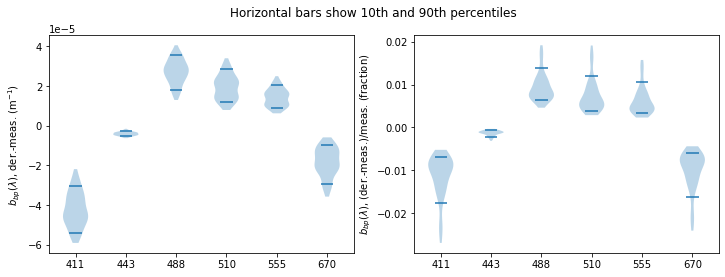

In [388]:
kwargs = {'positions':range(len(wvs)),'showextrema':False,'quantiles':np.tile(np.array([0.10,0.90]),[len(wvs),1]).T}
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.violinplot((all_bbp_der-all_bbp).T,**kwargs)
plt.xticks(range(6),wvs);
plt.ylabel(r'$b_{bp}(\lambda)$, der.-meas. (m$^{-1}$)')
plt.subplot(122)
plt.violinplot(((all_bbp_der-all_bbp)/all_bbp).T,**kwargs)
plt.xticks(range(6),wvs);
plt.ylabel(r'$b_{bp}(\lambda)$, (der.-meas.)/meas. (fraction)')
plt.suptitle('Horizontal bars show 10th and 90th percentiles');
plt.savefig('bbp_der_meas.png',dpi=300)

### Do all retrievals

In [92]:
import time as pytime

In [220]:
start = pytime.time()
giop_out_all = ()
for rrs,chl in zip(all_rrs.T,all_chl.T):
    #inds = np.
    giop_out_all += (getGiop.giop(wvs,rrs,np.diag((rrs*0.05)**2),chl=chl,
                        fq='gordon', inv='amoeba', sdg='qaa', error='relative'),)
end = pytime.time()
print('Execution time (seconds):',end - start)

Execution time (seconds): 2.3353641033172607


In [221]:
start = pytime.time()
giop2_out_all = ()
for rrs,chl in zip(all_rrs.T,all_chl.T):
    giop2_out_all += (getGiop.giop(wvs,rrs,np.diag((rrs*0.05)**2),chl=chl,
                        num_retr=5, fq='gordon', inv='amoeba', sdg='qaa', error='relative'),)
end = pytime.time()
print('Execution time (seconds):',end - start)

Execution time (seconds): 7.2719810009002686


In [222]:
start = pytime.time()
bayes_out_all = ()

priors = [np.concatenate((out[0],[out[4]],[out[5]])) for out in giop_out_all]
cov_pr_3var = [out[1] for out in giop_out_all]

for rrs,chl,prior,cov_3var in zip(all_rrs.T,all_chl.T,priors,cov_pr_3var):
    cov_prior = np.zeros(shape=(5,5))
    cov_prior[0:3,0:3] = cov_3var
    cov_prior[3,3] = 0.001**2
    cov_prior[4,4] = 0.1**2
    bayes_out_all += (getGiop.giop(wvs,rrs,np.diag((rrs*0.05)**2),chl=chl,
                         fq='gordon', inv='Bayes', sdg='qaa', error='relative',
                         num_retr=5, prior=prior, cov_prior=cov_prior),)

end = pytime.time()
print('Execution time (seconds):',end - start)

Execution time (seconds): 5.26544976234436


In [223]:
giop_out_vals = np.array([g[0] for g in giop_out_all])
giop2_out_vals = np.array([g[0] for g in giop2_out_all])
bayes_out_vals = np.array([g[0] for g in bayes_out_all])
giop2_out_vals[giop2_out_vals==-999] = np.nan
giop_out_sdg = np.array([g[4] for g in giop_out_all])
giop_out_eta = np.array([g[5] for g in giop_out_all])

In [336]:
MAE_all = np.array([((np.exp(np.mean(np.abs(np.log(der/rrs))))-1)*100) for der,rrs in zip(der_rrs.T,all_rrs.T)])
MAE_giop_all = np.array([((np.exp(np.mean(np.abs(np.log(out[6]/rrs))))-1)*100) for out,rrs in zip(giop_out_all,all_rrs.T)])
MAE_giop2_all = np.array([((np.exp(np.mean(np.abs(np.log(out[6]/rrs))))-1)*100) for out,rrs in zip(giop2_out_all,all_rrs.T)])
MAE_bayes_all = np.array([((np.exp(np.mean(np.abs(np.log(out[6]/rrs))))-1)*100) for out,rrs in zip(bayes_out_all,all_rrs.T)])


/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/1094465464.py:3: RuntimeWarning: invalid value encountered in log
  MAE_giop2_all = np.array([((np.exp(np.mean(np.abs(np.log(out[6]/rrs))))-1)*100) for out,rrs in zip(giop2_out_all,all_rrs.T)])


## pick one example

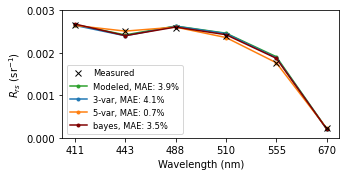

In [389]:
plt.figure(figsize=(5,2.5))
plt.plot(all_rrs[:,ex_ind],marker='x',label='Measured',c='k',ls='none',zorder=999)
plt.plot(der_rrs[:,ex_ind],marker='.',label='Modeled, MAE: %.1f%%'%MAE_all[ex_ind],c='C2')
plt.plot(giop_out_all[ex_ind][6],marker='.',label='3-var, MAE: %.1f%%'%MAE_giop_all[ex_ind],c='C0')
plt.plot(giop2_out_all[ex_ind][6],marker='.',label='5-var, MAE: %.1f%%'%MAE_giop2_all[ex_ind],c='C1')
plt.plot(bayes_out_all[ex_ind][6],marker='.',label='bayes, MAE: %.1f%%'%MAE_bayes_all[ex_ind],c='maroon')

plt.legend(fontsize='small')
plt.xticks(range(len(wvs)),wvs);
plt.xlabel('Wavelength (nm)')
plt.ylabel('$R_{rs}$ (sr$^{-1}$)')
plt.tight_layout()
plt.ylim([0,0.003])
plt.yticks([0,0.001,0.002,0.003]);

plt.savefig('rrs_ex.png',dpi=300,transparent=True)

In [227]:
def make_gaussian(x,mean,dev):
    return np.exp(-(x-mean)**2/(2*dev**2))/np.sqrt(2*np.pi*dev**2)

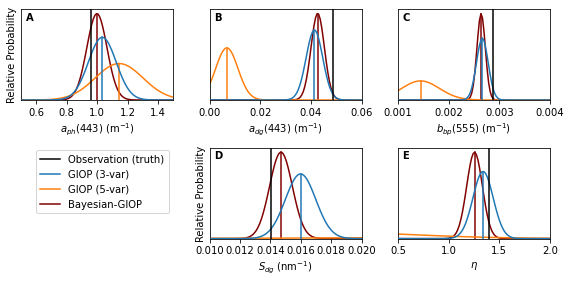

In [390]:
truths = (all_aph[1,ex_ind]/.055,all_adg[1,ex_ind],all_bbp[1,ex_ind],all_sdg[ex_ind],all_eta[ex_ind])
ranges = ([.5,1.5],[0,.06],[0.001,0.004],[0.01,0.02],[0.5,2])
fig,ax = plt.subplots(2,3,figsize=(8,4))
ax[1,0].set_visible(False)
ax = (ax[0,0],ax[0,1],ax[0,2],ax[1,1],ax[1,2])

# need to make the 3-var solution because the output has eta and Sdg in different places (because they aren't retrieved)
example_3var_sol = np.concatenate((giop_out_all[ex_ind][0],[giop_out_all[ex_ind][4]],[giop_out_all[ex_ind][5]]))
example_3var_covar = np.zeros(shape=(5,5))
example_3var_covar[0:3,0:3] = giop_out_all[ex_ind][1]
example_3var_covar[3,3] = 0.001**2
example_3var_covar[4,4] = 0.1**2

for i,a in enumerate(ax):
    # plot truth as vertical line
    a.axvline(truths[i],c='k',label='Observation (truth)',zorder=4)
    
    # set x var
    xx = np.linspace(ranges[i][0],ranges[i][1],100)
    
    # plot 3-var GIOP distribution and most-likely value
    g = make_gaussian(xx,example_3var_sol[i],example_3var_covar[i,i]**.5)
    a.plot(xx,g,c='C0',label='GIOP (3-var)',zorder=3)
    a.plot(example_3var_sol[[i,i]],[0,np.max(g)],c='C0',zorder=3)
    
    # plot 5-var GIOP distribution and most-likely value
    g = make_gaussian(xx,giop2_out_all[ex_ind][0][i],giop2_out_all[ex_ind][1][i,i]**.5)
    a.plot(xx,g,c='C1',label='GIOP (5-var)',zorder=2)
    a.plot(giop2_out_all[ex_ind][0][[i,i]],[0,np.max(g)],c='C1',zorder=2)
    
    # plot Bayes GIOP distribution and most-likely value
    g = make_gaussian(xx,bayes_out_all[ex_ind][0][i],bayes_out_all[ex_ind][7][i,i]**.5)
    a.plot(xx,g,c='maroon',label='Bayesian-GIOP',zorder=0)
    a.plot(bayes_out_all[ex_ind][0][[i,i]],[0,np.max(g)],c='maroon',zorder=0)
    
    a.set_xlim(ranges[i])
    a.set_ylim([0,None])
    a.set_yticks([])
for a,label in zip(ax,['$a_{ph}(443)$ (m$^{-1}$)','$a_{dg}(443)$ (m$^{-1}$)','$b_{bp}(555)$ (m$^{-1}$)','$S_{dg}$ (nm$^{-1}$)','$\eta$']):
    a.set_xlabel(label);
plt.tight_layout()
ax[0].legend(loc=(0.1,-1.25))
ax[0].set_ylabel('Relative Probability')
ax[3].set_ylabel('Relative Probability')
for a,letter in zip(ax,['A','B','C','D','E']):
    a.annotate(letter,(0.03,0.88),xycoords='axes fraction',fontweight='bold')
plt.savefig('result_ex.png',dpi=300)

In [230]:
print(' \t\t Truth \t pygiop \t Bayes \t\t pygiop (5var)')
print('a_ph(443) \t %.2f \t %.2f (%.2f)\t %.2f (%.2f)\t %.2f (%.2f)'%
      (all_aph[1,ex_ind]/.055, giop_out_all[ex_ind][0][0], (giop_out_all[ex_ind][1][0,0])**.5, bayes_out_all[ex_ind][0][0], (bayes_out_all[ex_ind][7][0,0])**.5, giop2_out_all[ex_ind][0][0], (giop2_out_all[ex_ind][1][0,0])**.5))
print('a_dg(443) \t %.3f \t %.3f (%.3f)\t %.3f (%.3f)\t %.3f (%.3f)'%
      (all_adg[1,ex_ind], giop_out_all[ex_ind][0][1], giop_out_all[ex_ind][1][1,1]**.5, bayes_out_all[ex_ind][0][1], bayes_out_all[ex_ind][7][1,1]**.5, giop2_out_all[ex_ind][0][1], giop2_out_all[ex_ind][1][1,1]**.5))
print('b_bp(443) \t %.4f\t %.4f (%.4f) %.4f (%.4f) %.4f (%.4f)'%
      (all_bbp[1,ex_ind], giop_out_all[ex_ind][0][2], giop_out_all[ex_ind][1][2,2]**.5, bayes_out_all[ex_ind][0][2], bayes_out_all[ex_ind][7][2,2]**.5, giop2_out_all[ex_ind][0][2], giop2_out_all[ex_ind][1][2,2]**.5))
print('   S_dg   \t %.3f \t %.3f \t\t %.3f (%.3f)\t %.3f (%.3f)'%
      (all_sdg[ex_ind], giop_out_all[ex_ind][4], bayes_out_all[ex_ind][0][3], bayes_out_all[ex_ind][7][3,3]**.5, giop2_out_all[ex_ind][0][3], giop2_out_all[ex_ind][1][3,3]**.5))
print('    eta   \t %.2f \t %.2f \t\t %.2f  (%.2f)\t %.2f  (%.2f)'%
      (all_eta[ex_ind], giop_out_all[ex_ind][5], bayes_out_all[ex_ind][0][4], bayes_out_all[ex_ind][7][4,4]**.5, giop2_out_all[ex_ind][0][4], giop2_out_all[ex_ind][1][4,4]**.5))

 		 Truth 	 pygiop 	 Bayes 		 pygiop (5var)
a_ph(443) 	 0.96 	 1.03 (0.09)	 1.00 (0.07)	 1.14 (0.16)
a_dg(443) 	 0.049 	 0.041 (0.003)	 0.043 (0.003)	 0.007 (0.004)
b_bp(443) 	 0.0029	 0.0027 (0.0001) 0.0026 (0.0001) 0.0014 (0.0004)
   S_dg   	 0.014 	 0.016 		 0.015 (0.001)	 0.052 (0.019)
    eta   	 1.44 	 1.34 		 1.26  (0.08)	 -0.39  (0.96)


Text(0.5, 0, 'MAE, pygiop (3-var)')

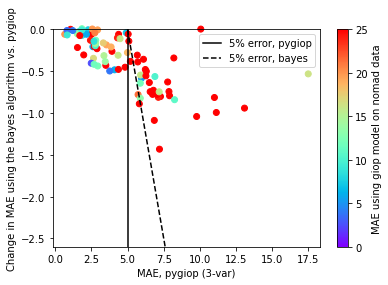

In [ ]:
plt.scatter(MAE_giop_all,MAE_bayes_all-MAE_giop_all,c=MAE_all,vmin=0,vmax=25,cmap=plt.cm.rainbow,clip_on=False)
plt.colorbar(label='MAE using giop model on nomad data')
plt.ylim([-2.6,0])
plt.plot([5,5],[-2.6,0],c='k',ls='-',label='5% error, pygiop')
plt.plot([5,10],[0,-5],c='k',ls='--',label='5% error, bayes')
plt.legend(loc=0,handlelength=1.8)
plt.ylabel('Change in MAE using the bayes algorithm vs. pygiop')
plt.xlabel('MAE, pygiop (3-var)')

38 retrievals (out of 86) have higher MAE than 25%


Text(0.5, 0, 'Retrieval number (sorted)')

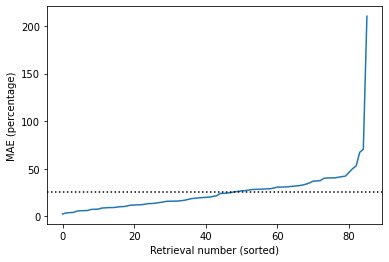

In [241]:
print(np.sum(MAE_all>25),'retrievals (out of %d) have higher MAE than 25%%'%len(all_idx))
plt.plot(np.sort(MAE_all))
plt.axhline(25,c='k',ls=':');
plt.ylabel('MAE (percentage)')
plt.xlabel('Retrieval number (sorted)')

In [339]:
print(np.nanpercentile(MAE_giop_all,[25,50,75]))
print(np.nanmean(MAE_all),np.nanstd(MAE_all),np.nanmedian(MAE_all))
print(np.nanmean(MAE_giop_all),np.nanstd(MAE_giop_all),np.nanmedian(MAE_giop_all))
print(np.nanmean(MAE_bayes_all),np.nanstd(MAE_bayes_all),np.nanmedian(MAE_bayes_all))
print(np.nanmean(MAE_giop2_all),np.nanstd(MAE_giop2_all),np.nanmedian(MAE_giop2_all))

[2.68464627 4.24204274 6.48633564]
25.408954313157274 24.417316111222043 21.203679660390108
4.786713726030713 2.8981753681168034 4.242042739126706
4.392344213316904 2.6576823194859367 3.957259194473861
1.0000107030908925 0.770856674440517 0.822410744000801


## Bunches of NOMAD stats

/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/2523938210.py:15: RuntimeWarning: invalid value encountered in log
  ax[1].plot(centers,np.histogram(np.log(giop_out_vals[:,1]/all_adg[1]),edges)[0],c='C0',label='GIOP (3-var)',**kwargs)
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/2523938210.py:16: RuntimeWarning: invalid value encountered in log
  ax[1].plot(centers,np.histogram(np.log(giop2_out_vals[:,1]/all_adg[1]),edges)[0],c='C1',label='GIOP (5-var)',**kwargs)
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/2523938210.py:17: RuntimeWarning: invalid value encountered in log
  ax[1].plot(centers,np.histogram(np.log(bayes_out_vals[:,1]/all_adg[1]),edges)[0],c='maroon',label='Bayesian-GIOP',**kwargs)
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/2523938210.py:24: RuntimeWarning: invalid value encountered in log
  ax[3].plot(centers,np.histogram(np.log(giop2_out_vals[:,3]/all_sdg),edges)[0],c='C1',label='GIOP (5-var

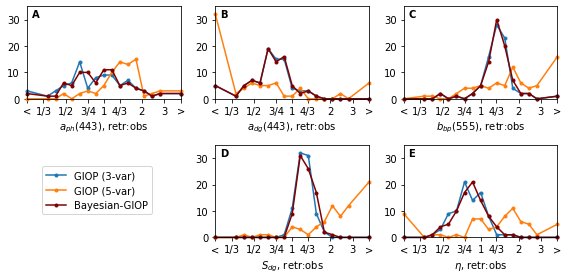

In [391]:
fig,ax = plt.subplots(2,3,figsize=(8,4))
ax[1,0].set_visible(False)
ax = (ax[0,0],ax[0,1],ax[0,2],ax[1,1],ax[1,2])

kwargs = {'marker':'.','clip_on':False}

edges = np.linspace(np.log(1/3),np.log(3),16); centers = edges[:-1]+np.diff(edges)/2
edges = np.concatenate(([-np.inf],edges,[np.inf]))
centers = np.concatenate(([-1.4],centers,[1.4]))

ax[0].plot(centers,np.histogram(np.log(giop_out_vals[:,0]/(all_aph[1]/.055)),edges)[0],c='C0',label='GIOP (3-var)',**kwargs)
ax[0].plot(centers,np.histogram(np.log(giop2_out_vals[:,0]/(all_aph[1]/.055)),edges)[0],c='C1',label='GIOP (5-var)',**kwargs)
ax[0].plot(centers,np.histogram(np.log(bayes_out_vals[:,0]/(all_aph[1]/.055)),edges)[0],c='maroon',label='Bayesian-GIOP',**kwargs)

ax[1].plot(centers,np.histogram(np.log(giop_out_vals[:,1]/all_adg[1]),edges)[0],c='C0',label='GIOP (3-var)',**kwargs)
ax[1].plot(centers,np.histogram(np.log(giop2_out_vals[:,1]/all_adg[1]),edges)[0],c='C1',label='GIOP (5-var)',**kwargs)
ax[1].plot(centers,np.histogram(np.log(bayes_out_vals[:,1]/all_adg[1]),edges)[0],c='maroon',label='Bayesian-GIOP',**kwargs)

ax[2].plot(centers,np.histogram(np.log(giop_out_vals[:,2]/all_bbp[4]),edges)[0],c='C0',label='GIOP (3-var)',**kwargs)
ax[2].plot(centers,np.histogram(np.log(giop2_out_vals[:,2]/all_bbp[4]),edges)[0],c='C1',label='GIOP (5-var)',**kwargs)
ax[2].plot(centers,np.histogram(np.log(bayes_out_vals[:,2]/all_bbp[4]),edges)[0],c='maroon',label='Bayesian-GIOP',**kwargs)

ax[3].plot(centers,np.histogram(np.log(giop_out_sdg/all_sdg),edges)[0],c='C0',label='GIOP (3-var)',**kwargs)
ax[3].plot(centers,np.histogram(np.log(giop2_out_vals[:,3]/all_sdg),edges)[0],c='C1',label='GIOP (5-var)',**kwargs)
ax[3].plot(centers,np.histogram(np.log(bayes_out_vals[:,3]/all_sdg),edges)[0],c='maroon',label='Bayesian-GIOP',**kwargs)

ax[4].plot(centers,np.histogram(np.log(giop_out_eta/all_eta),edges)[0],c='C0',label='GIOP (3-var)',**kwargs)
ax[4].plot(centers,np.histogram(np.log(giop2_out_vals[:,4]/all_eta),edges)[0],c='C1',label='GIOP (5-var)',**kwargs)
ax[4].plot(centers,np.histogram(np.log(bayes_out_vals[:,4]/all_eta),edges)[0],c='maroon',label='Bayesian-GIOP',**kwargs)

for a in ax:
    a.set_xticks(np.log([np.exp(-1.4),1/3,.5,3/4,1,4/3,2,3,np.exp(1.4)]))
    a.set_xticklabels(['<','1/3','1/2','3/4',1,'4/3','2','3','>'],fontsize='10')
    a.set_ylim([0,35])
    a.set_xlim([-1.4,1.4])

for a,label in zip(ax,['$a_{ph}(443)$','$a_{dg}(443)$','$b_{bp}(555)$','$S_{dg}$','$\eta$']):
    a.set_xlabel(label+', retr:obs');
plt.tight_layout()
ax[0].legend(loc=(0.1,-1.25))
for a,letter in zip(ax,['A','B','C','D','E']):
    a.annotate(letter,(0.03,0.88),xycoords='axes fraction',fontweight='bold')
plt.savefig('results_all.png',dpi=300)

### a_ph

In [204]:
print('3-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop_out_vals[:,0])-np.log(all_aph[1]/.055))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop_out_vals[:,0])-np.log(all_aph[1]/.055)))))
print('% wins (1)',np.sum(np.abs(giop_out_vals[:,0]-all_aph[1]/.055)<np.abs(bayes_out_vals[:,0]-all_aph[1]/.055))/np.sum(np.isfinite(giop_out_vals[:,0]*bayes_out_vals[:,0])))
print('% wins (2)',np.sum(np.abs(giop_out_vals[:,0]-all_aph[1]/.055)<np.abs(giop2_out_vals[:,0]-all_aph[1]/.055))/np.sum(np.isfinite(giop_out_vals[:,0]*giop2_out_vals[:,0])))
print('% wins',(0.20930+0.64935)/2)

3-variable stats
Bias factor 0.9095536593176674
MAE 1.5956677705955047
% wins (1) 0.20930232558139536
% wins (2) 0.6493506493506493
% wins 0.429325


In [205]:
print('bayesian stats')
print('Bias factor',np.exp(np.nanmean(np.log(bayes_out_vals[:,0])-np.log(all_aph[1]/.055))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(bayes_out_vals[:,0])-np.log(all_aph[1]/.055)))))
print('% wins (1)',np.sum(np.abs(bayes_out_vals[:,0]-all_aph[1]/.055)<np.abs(giop_out_vals[:,0]-all_aph[1]/.055))/np.sum(np.isfinite(bayes_out_vals[:,0]*giop_out_vals[:,0])))
print('% wins (2)',np.sum(np.abs(bayes_out_vals[:,0]-all_aph[1]/.055)<np.abs(giop2_out_vals[:,0]-all_aph[1]/.055))/np.sum(np.isfinite(bayes_out_vals[:,0]*giop2_out_vals[:,0])))
print('% wins',(0.79070+0.70130)/2)

bayesian stats
Bias factor 0.9472423903829188
MAE 1.5308491960810344
% wins (1) 0.7906976744186046
% wins (2) 0.6623376623376623
% wins 0.746


In [206]:
print('5-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,0])-np.log(all_aph[1]/.055))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,0])-np.log(all_aph[1]/.055)))))
print('% wins (1)',np.sum(np.abs(giop2_out_vals[:,0]-all_aph[1]/.055)<np.abs(giop_out_vals[:,0]-all_aph[1]/.055))/np.sum(np.isfinite(giop2_out_vals[:,0]*giop_out_vals[:,0])))
print('% wins (2)',np.sum(np.abs(giop2_out_vals[:,0]-all_aph[1]/.055)<np.abs(bayes_out_vals[:,0]-all_aph[1]/.055))/np.sum(np.isfinite(giop2_out_vals[:,0]*bayes_out_vals[:,0])))
print('% wins',(0.35065+0.29870)/2)

5-variable stats
Bias factor 1.5334513640639544
MAE 1.5774580149701096
% wins (1) 0.35064935064935066
% wins (2) 0.33766233766233766
% wins 0.32467500000000005


/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/465673257.py:2: RuntimeWarning: invalid value encountered in log
  print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,0])-np.log(all_aph[1]/.055))))
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/465673257.py:3: RuntimeWarning: invalid value encountered in log
  print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,0])-np.log(all_aph[1]/.055)))))


### a_dg

In [207]:
print('3-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop_out_vals[:,1])-np.log(all_adg[1]))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop_out_vals[:,1])-np.log(all_adg[1])))))
print('% wins (1)',np.sum(np.abs(giop_out_vals[:,1]-all_adg[1])<np.abs(bayes_out_vals[:,1]-all_adg[1]))/np.sum(np.isfinite(giop_out_vals[:,1]*bayes_out_vals[:,1])))
print('% wins (2)',np.sum(np.abs(giop_out_vals[:,1]-all_adg[1])<np.abs(giop2_out_vals[:,1]-all_adg[1]))/np.sum(np.isfinite(giop_out_vals[:,1]*giop2_out_vals[:,1])))
print('% wins',(0.65116+0.92208)/2)

3-variable stats
Bias factor 0.6497045551391671
MAE 1.6031016431414975
% wins (1) 0.6511627906976745
% wins (2) 0.922077922077922
% wins 0.78662


/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/909781636.py:2: RuntimeWarning: invalid value encountered in log
  print('Bias factor',np.exp(np.nanmean(np.log(giop_out_vals[:,1])-np.log(all_adg[1]))))
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/909781636.py:3: RuntimeWarning: invalid value encountered in log
  print('MAE',np.exp(np.nanmean(np.abs(np.log(giop_out_vals[:,1])-np.log(all_adg[1])))))


In [208]:
print('bayesian stats')
print('Bias factor',np.exp(np.nanmean(np.log(bayes_out_vals[:,1])-np.log(all_adg[1]))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(bayes_out_vals[:,1])-np.log(all_adg[1])))))
print('% wins (1)',np.sum(np.abs(bayes_out_vals[:,1]-all_adg[1])<np.abs(giop_out_vals[:,1]-all_adg[1]))/np.sum(np.isfinite(bayes_out_vals[:,1]*giop_out_vals[:,1])))
print('% wins (2)',np.sum(np.abs(bayes_out_vals[:,1]-all_adg[1])<np.abs(giop2_out_vals[:,1]-all_adg[1]))/np.sum(np.isfinite(bayes_out_vals[:,1]*giop2_out_vals[:,1])))
print('% wins',(0.34884+0.90909)/2)

bayesian stats
Bias factor 0.6469046426784568
MAE 1.6082622700886435
% wins (1) 0.3488372093023256
% wins (2) 0.935064935064935
% wins 0.628965


/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/443779871.py:2: RuntimeWarning: invalid value encountered in log
  print('Bias factor',np.exp(np.nanmean(np.log(bayes_out_vals[:,1])-np.log(all_adg[1]))))
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/443779871.py:3: RuntimeWarning: invalid value encountered in log
  print('MAE',np.exp(np.nanmean(np.abs(np.log(bayes_out_vals[:,1])-np.log(all_adg[1])))))


In [209]:
print('5-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,1])-np.log(all_adg[1]))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,1])-np.log(all_adg[1])))))
print('% wins (1)',np.sum(np.abs(giop2_out_vals[:,1]-all_adg[1])<np.abs(giop_out_vals[:,1]-all_adg[1]))/np.sum(np.isfinite(giop2_out_vals[:,1]*giop_out_vals[:,1])))
print('% wins (2)',np.sum(np.abs(giop2_out_vals[:,1]-all_adg[1])<np.abs(bayes_out_vals[:,1]-all_adg[1]))/np.sum(np.isfinite(giop2_out_vals[:,1]*bayes_out_vals[:,1])))
print('% wins',(0.07792+0.09091)/2)

5-variable stats
Bias factor 0.36338521028656023
MAE 3.5031968731546894
% wins (1) 0.07792207792207792
% wins (2) 0.06493506493506493
% wins 0.084415


/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/1446648936.py:2: RuntimeWarning: invalid value encountered in log
  print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,1])-np.log(all_adg[1]))))
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/1446648936.py:3: RuntimeWarning: invalid value encountered in log
  print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,1])-np.log(all_adg[1])))))


### b_bp

In [210]:
print('3-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop_out_vals[:,2])-np.log(all_bbp[4]))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop_out_vals[:,2])-np.log(all_bbp[4])))))
print('% wins (1)',np.sum(np.abs(giop_out_vals[:,2]-all_bbp[4])<np.abs(bayes_out_vals[:,2]-all_bbp[4]))/np.sum(np.isfinite(giop_out_vals[:,2]*bayes_out_vals[:,2])))
print('% wins (2)',np.sum(np.abs(giop_out_vals[:,2]-all_bbp[4])<np.abs(giop2_out_vals[:,2]-all_bbp[4]))/np.sum(np.isfinite(giop_out_vals[:,2]*giop2_out_vals[:,2])))
print('% wins',(0.70930+0.77922)/2)

3-variable stats
Bias factor 1.3507928307165515
MAE 1.4240433686102154
% wins (1) 0.6976744186046512
% wins (2) 0.7792207792207793
% wins 0.74426


In [211]:
print('bayesian stats')
print('Bias factor',np.exp(np.nanmean(np.log(bayes_out_vals[:,2])-np.log(all_bbp[4]))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(bayes_out_vals[:,2])-np.log(all_bbp[4])))))
print('% wins (1)',np.sum(np.abs(bayes_out_vals[:,2]-all_bbp[4])<np.abs(giop_out_vals[:,2]-all_bbp[4]))/np.sum(np.isfinite(bayes_out_vals[:,2]*giop_out_vals[:,2])))
print('% wins (2)',np.sum(np.abs(bayes_out_vals[:,2]-all_bbp[4])<np.abs(giop2_out_vals[:,2]-all_bbp[4]))/np.sum(np.isfinite(bayes_out_vals[:,2]*giop2_out_vals[:,2])))
print('% wins',(0.29070+0.76623)/2)

bayesian stats
Bias factor 1.3704680881181655
MAE 1.4415357245492824
% wins (1) 0.3023255813953488
% wins (2) 0.7792207792207793
% wins 0.528465


In [212]:
print('5-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,2])-np.log(all_bbp[4]))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,2])-np.log(all_bbp[4])))))
print('% wins (1)',np.sum(np.abs(giop2_out_vals[:,2]-all_bbp[4])<np.abs(giop_out_vals[:,2]-all_bbp[4]))/np.sum(np.isfinite(giop2_out_vals[:,2]*giop_out_vals[:,2])))
print('% wins (2)',np.sum(np.abs(giop2_out_vals[:,2]-all_bbp[4])<np.abs(bayes_out_vals[:,2]-all_bbp[4]))/np.sum(np.isfinite(giop2_out_vals[:,2]*bayes_out_vals[:,2])))
print('% wins',(0.22078+0.23377)/2)

5-variable stats
Bias factor 1.8795064856406802
MAE 2.0287979118866515
% wins (1) 0.22077922077922077
% wins (2) 0.22077922077922077
% wins 0.227275


### S_dg

In [213]:
print('3-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop_out_sdg)-np.log(all_sdg))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop_out_sdg)-np.log(all_sdg)))))
print('% wins (1)',np.sum(np.abs(giop_out_sdg-all_sdg)<np.abs(bayes_out_vals[:,3]-all_sdg))/np.sum(np.isfinite(giop_out_sdg*bayes_out_vals[:,3])))
print('% wins (2)',np.sum(np.abs(giop_out_sdg-all_sdg)<np.abs(giop2_out_vals[:,3]-all_sdg))/np.sum(np.isfinite(giop_out_sdg*giop2_out_vals[:,3])))
print('% wins',(0.72093+0.94805)/2)

3-variable stats
Bias factor 1.2126052018508082
MAE 1.2324594751458025
% wins (1) 0.6627906976744186
% wins (2) 0.935064935064935
% wins 0.83449


In [214]:
print('bayesian stats')
print('Bias factor',np.exp(np.nanmean(np.log(bayes_out_vals[:,3])-np.log(all_sdg))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(bayes_out_vals[:,3])-np.log(all_sdg)))))
print('% wins (1)',np.sum(np.abs(bayes_out_vals[:,3]-all_sdg)<np.abs(giop_out_sdg-all_sdg))/np.sum(np.isfinite(bayes_out_vals[:,3]*giop_out_sdg)))
print('% wins (2)',np.sum(np.abs(bayes_out_vals[:,3]-all_sdg)<np.abs(giop2_out_vals[:,3]-all_sdg))/np.sum(np.isfinite(bayes_out_vals[:,3]*giop2_out_vals[:,3])))
print('% wins',(0.27907+0.94805)/2)

bayesian stats
Bias factor 1.2515359861150799
MAE 1.2608210492263685
% wins (1) 0.3372093023255814
% wins (2) 0.948051948051948
% wins 0.61356


In [215]:
print('5-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,3])-np.log(all_sdg))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,3])-np.log(all_sdg)))))
print('% wins (1)',np.sum(np.abs(giop2_out_vals[:,3]-all_sdg)<np.abs(giop_out_sdg-all_sdg))/np.sum(np.isfinite(giop2_out_vals[:,3]*giop_out_sdg)))
print('% wins (2)',np.sum(np.abs(giop2_out_vals[:,3]-all_sdg)<np.abs(bayes_out_vals[:,3]-all_sdg))/np.sum(np.isfinite(giop2_out_vals[:,3]*bayes_out_vals[:,3])))
print('% wins',(0.05195+0.05195)/2)

5-variable stats
Bias factor 2.5427921515968723
MAE 2.619208035919179
% wins (1) 0.06493506493506493
% wins (2) 0.05194805194805195
% wins 0.05195


/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/2673819789.py:2: RuntimeWarning: invalid value encountered in log
  print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,3])-np.log(all_sdg))))
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/2673819789.py:3: RuntimeWarning: invalid value encountered in log
  print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,3])-np.log(all_sdg)))))


### eta

In [216]:
print('3-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop_out_eta)-np.log(all_eta))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop_out_eta)-np.log(all_eta)))))
print('% wins (1)',np.sum(np.abs(giop_out_eta-all_eta)<np.abs(bayes_out_vals[:,4]-all_eta))/np.sum(np.isfinite(giop_out_eta*bayes_out_vals[:,4])))
print('% wins (2)',np.sum(np.abs(giop_out_eta-all_eta)<np.abs(giop2_out_vals[:,4]-all_eta))/np.sum(np.isfinite(giop_out_eta*giop2_out_vals[:,4])))
print('% wins',(0.43023+0.76623)/2)

3-variable stats
Bias factor 0.7900544885701097
MAE 1.3282746229496738
% wins (1) 0.38372093023255816
% wins (2) 0.7662337662337663
% wins 0.59823


In [217]:
print('bayesian stats')
print('Bias factor',np.exp(np.nanmean(np.log(bayes_out_vals[:,4])-np.log(all_eta))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(bayes_out_vals[:,4])-np.log(all_eta)))))
print('% wins (1)',np.sum(np.abs(bayes_out_vals[:,4]-all_eta)<np.abs(giop_out_eta-all_eta))/np.sum(np.isfinite(bayes_out_vals[:,4]*giop_out_eta)))
print('% wins (2)',np.sum(np.abs(bayes_out_vals[:,4]-all_eta)<np.abs(giop2_out_vals[:,4]-all_eta))/np.sum(np.isfinite(bayes_out_vals[:,4]*giop2_out_vals[:,4])))
print('% wins',(0.56977+0.79221)/2)

bayesian stats
Bias factor 0.8181281466183947
MAE 1.3077510574122626
% wins (1) 0.6162790697674418
% wins (2) 0.7662337662337663
% wins 0.68099


In [218]:
print('5-variable stats')
print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,4])-np.log(all_eta))))
print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,4])-np.log(all_eta)))))
print('% wins (1)',np.sum(np.abs(giop2_out_vals[:,4]-all_eta)<np.abs(giop_out_eta-all_eta))/np.sum(np.isfinite(giop2_out_vals[:,4]*giop_out_eta)))
print('% wins (2)',np.sum(np.abs(giop2_out_vals[:,4]-all_eta)<np.abs(bayes_out_vals[:,4]-all_eta))/np.sum(np.isfinite(giop2_out_vals[:,4]*bayes_out_vals[:,4])))
print('% wins',(0.23377+0.20779)/2)

5-variable stats
Bias factor 1.077375407647462
MAE 1.9609093557321422
% wins (1) 0.23376623376623376
% wins (2) 0.23376623376623376
% wins 0.22078


/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/3252417619.py:2: RuntimeWarning: invalid value encountered in log
  print('Bias factor',np.exp(np.nanmean(np.log(giop2_out_vals[:,4])-np.log(all_eta))))
/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_10920/3252417619.py:3: RuntimeWarning: invalid value encountered in log
  print('MAE',np.exp(np.nanmean(np.abs(np.log(giop2_out_vals[:,4])-np.log(all_eta)))))


(array([ 1.,  4.,  7., 20., 18., 19.,  8.,  5.,  2.,  2.]),
 array([0.00825014, 0.00934311, 0.01043607, 0.01152904, 0.01262201,
        0.01371497, 0.01480794, 0.0159009 , 0.01699387, 0.01808684,
        0.0191798 ]),
 <BarContainer object of 10 artists>)

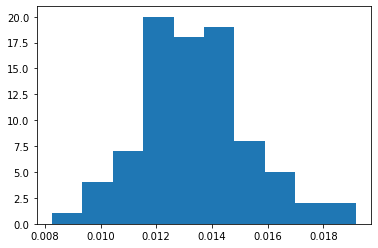

In [381]:
#plt.hist(giop_out_sdg)
plt.hist(all_sdg)

## Do Monte Carlo about one example to test the different versions

In [285]:
rrs = all_rrs[:,ex_ind]
chl = all_chl[ex_ind]
giop_out_mc = np.empty(shape=(500,5))
giop2_out_mc = np.empty(shape=(500,5))
bayes_out_mc = np.empty(shape=(500,5))
for i in range(500):
    print('.',end='')
    rrs_new = rrs*(0.05*np.random.randn(len(wvs))+1) # add random 5% error
    giop_out = getGiop.giop(wvs,rrs_new,np.diag((rrs*0.05)**2),chl=chl,fq='gordon', inv='amoeba', sdg='qaa', error='relative')
    giop_vals = np.concatenate((giop_out[0],[giop_out[4]],[giop_out[5]]))
    giop_cov = np.zeros(shape=(5,5))
    giop_cov[0:3,0:3] = giop_out[1]
    giop_cov[3,3] = 0.001**2
    giop_cov[4,4] = 0.1**2
    giop2_out = getGiop.giop(wvs,rrs_new,np.diag((rrs*0.05)**2),chl=chl,num_retr=5, fq='gordon', inv='amoeba', sdg='qaa', error='relative')
    bayes_out = getGiop.giop(wvs,rrs_new,np.diag((rrs*0.05)**2),chl=chl,num_retr=5, fq='gordon', inv='Bayes', sdg='qaa', error='relative',prior=giop_vals, cov_prior=giop_cov)
    
    giop_out_mc[i] = giop_vals
    giop2_out_mc[i] = giop2_out[0]
    bayes_out_mc[i] = bayes_out[0]

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [290]:
giop2_out_mc[giop2_out_mc==-999] = np.nan

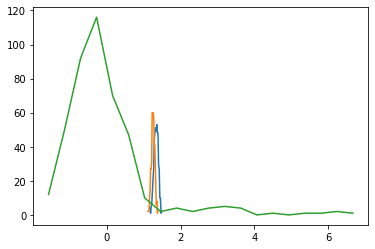

In [310]:
i = 4;
val,ed = np.histogram(giop_out_mc[:,i],20)
c = ed[:-1]+np.diff(ed)/2
plt.plot(c,val)
val,ed = np.histogram(bayes_out_mc[:,i],20)
c = ed[:-1]+np.diff(ed)/2
plt.plot(c,val)
val,ed = np.histogram(giop2_out_mc[np.isfinite(giop2_out_mc[:,i]),i],20)
c = ed[:-1]+np.diff(ed)/2
plt.plot(c,val)


In [305]:
np.sum(val)

424

(array([  1.,   2.,   2.,   1.,   0.,  10.,  28., 144., 202.,  34.]),
 array([-1.59698788, -1.27090021, -0.94481253, -0.61872486, -0.29263718,
         0.03345049,  0.35953817,  0.68562584,  1.01171352,  1.33780119,
         1.66388886]),
 <BarContainer object of 10 artists>)

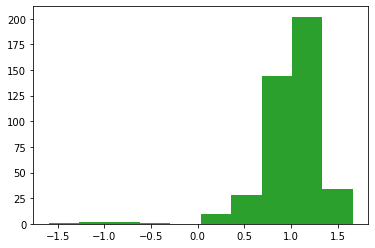

In [293]:
plt.hist(giop_out_mc[:,0])
plt.hist(bayes_out_mc[:,0])
plt.hist(giop2_out_mc[:,0])

In [270]:
np.sqrt(np.diag(giop2_out[1]))

array([1.57081724e-01, 4.38551930e-03, 3.73704148e-04, 1.87078025e-02,
       9.59722439e-01])

In [267]:
np.sqrt(np.diag(bayes_out[1]))

array([2.24542813e-01, 3.07029547e-02, 1.43254253e-03, 5.77906591e-03,
       1.59063586e+00])

In [268]:
np.sqrt(np.diag(bayes_out[7]))

array([6.62616549e-02, 2.64031934e-03, 8.25111369e-05, 7.48062165e-04,
       7.78222471e-02])

In [263]:
print(giop_vals)
print(giop2_out[0])
print(bayes_out[0])

[1.03329294 0.04137131 0.00266398 0.01598368 1.33926503]
[ 1.1439216   0.0068017   0.00144495  0.05175452 -0.39136798]
[0.99801837 0.04266267 0.00264054 0.01469474 1.25522494]


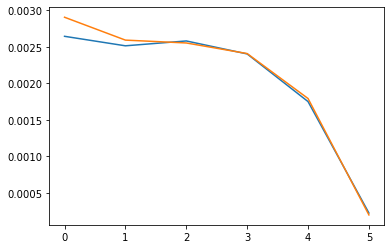

In [282]:
plt.plot(rrs),
plt.plot(rrs*(np.random.randn(len(wvs))*.05+1))

In [258]:
giop_cov

NameError: name 'giop_cov' is not defined

## Figure for full dataset

### Do retrievals for an image

In [192]:
from netCDF4 import Dataset

In [193]:
#l1b = Dataset('../Figures/A2018272172500.L1B_LAC.sub','r')
l2b_giop = Dataset('../Figures/A2018272172500.L2_LAC_IOP.sub','r')
l2b_rrs = Dataset('../Figures/A2018272172500.L2_LAC_OC.sub','r')
#l2b_giop = Dataset('../Figures/SEASTAR_SEAWIFS_GAC.20001201T221440.L2.IOP.nc','r')
#l2b_rrs = Dataset('../Figures/SEASTAR_SEAWIFS_GAC.20001201T221440.L2.OC.nc','r')

In [194]:
wv = np.array([412,443,490,510,555,670])
wv = np.array([412,443,469,488,531,547,555,645,667,678])
Rrss = np.array([l2b_rrs.groups['geophysical_data'].variables['Rrs_%03d'%w][:] for w in wv])

In [195]:
ss = 5
longitude = l2b_rrs.groups['navigation_data'].variables['longitude'][::ss][:,::ss]
latitude = l2b_rrs.groups['navigation_data'].variables['latitude'][::ss][:,::ss]
chlor_a = l2b_rrs.groups['geophysical_data'].variables['chlor_a'][::ss][:,::ss]
Rrss = Rrss[:,::ss][:,:,::ss]

In [123]:
ss = 1
longitude = l2b_rrs.groups['navigation_data'].variables['longitude'][:].data
latitude = l2b_rrs.groups['navigation_data'].variables['latitude'][:].data
latinds = (np.max(latitude,axis=1)>17) & (np.min(latitude,axis=1)<22)
latitude = latitude[latinds]
longitude = longitude[latinds]
loninds = (np.max(longitude,axis=0)>-158) & (np.min(longitude,axis=0)<-153)
latitude = latitude[:,loninds]
longitude = longitude[:,loninds]
chlor_a = l2b_rrs.groups['geophysical_data'].variables['chlor_a'][latinds,loninds]
Rrss = np.array([l2b_rrs.groups['geophysical_data'].variables['Rrs_%03d'%w][latinds,loninds] for w in wv])
#Rrss = Rrss[:,inds]

ValueError: zero-size array to reduction operation maximum which has no identity

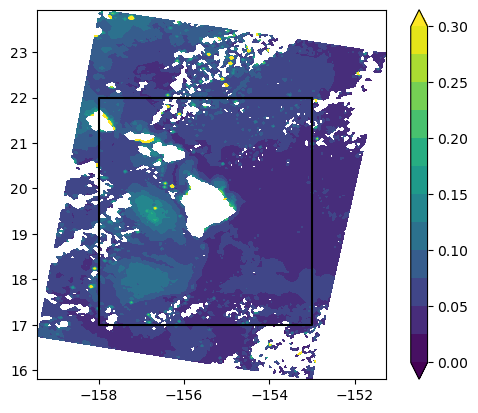

In [656]:
plt.contourf(longitude,latitude,chlor_a,levels=np.arange(0,.3001,.025),extend='both')
plt.plot([-153,-153,-158,-158,-153],[22,17,17,22,22],c='k')
plt.colorbar()
plt.gca().set_aspect(1/np.cos(20*np.pi/180))

In [445]:
plt.style.use('default')

/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_51625/2812284978.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = map.pcolormesh(x,y,chlor_a,vmin=0,vmax=2)


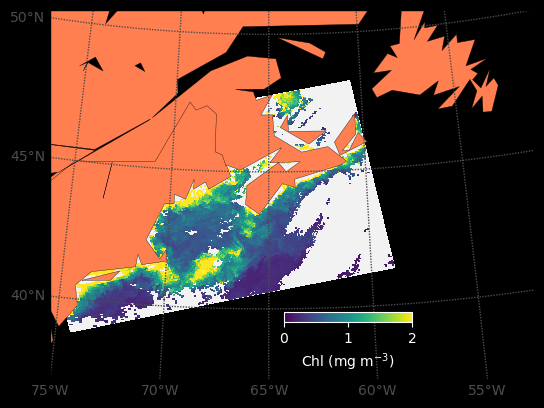

In [446]:
plt.style.use("dark_background")
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
#map = Basemap(projection='gnom',llcrnlon=0,llcrnlat,30,urcrnlon=-50+360,urcrnlat=50,lat_0=45,lon_0=-100,resolution='l',height=1000)
map = Basemap(projection='stere',lon_0=-65,lat_0=40,\
            llcrnrlat=37,urcrnrlat=50,\
            llcrnrlon=-75,urcrnrlon=-50,area_thresh=1000)
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='coral',lake_color='black')
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='black')
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,5),labels=[0,0,0,1],color='0.3',textcolor='0.3')
map.drawparallels(np.arange(-90,90,5),labels=[1,0,0,0],color='0.3',textcolor='0.3')
# make up some data on a regular lat/lon grid.
x,y = map(longitude,latitude)
map.contourf(x,y,np.ones(shape=(longitude.shape)),colors='0.95')
c = map.pcolormesh(x,y,chlor_a,vmin=0,vmax=2)
cax = plt.axes([.5,.23,.2,.02])
plt.colorbar(c,cax=cax,orientation='horizontal',label='Chl (mg m$^{-3}$)')

#plt.savefig('kernel_map.png',dpi=300,transparent=False,facecolor='w',backgroundcolor='w')

In [666]:
shape1 = (Rrss.shape[1],Rrss.shape[2],5)
shape2 = (Rrss.shape[1],Rrss.shape[2],5,5)
shape3 = (Rrss.shape[1],Rrss.shape[2],len(wv))
scene_pygiop = np.nan*np.empty(shape=shape1)
scene_pygiop_covar = np.zeros(shape=shape2)
scene_pygiop_rrs = np.nan*np.empty(shape=shape3)
scene_pygiop_5var = np.nan*np.empty(shape=shape1)
scene_pygiop_5var_covar = np.zeros(shape=shape2)
scene_pygiop_5var_rrs = np.nan*np.empty(shape=shape3)
scene_bayes = np.nan*np.empty(shape=shape1)
scene_bayes_covar = np.zeros(shape=shape2)
scene_bayes_rrs = np.nan*np.empty(shape=shape3)

print([shape1[0],shape1[1]])


for i in range(shape1[0]):
    print(i,end='')
    for j in range(shape1[1]):
        if np.mod(j,5)==0:
            print('.',end='')
        if np.any(Rrss[:,i,j]<0):
            continue
        ##########
        out = getGiop.giop(wv,Rrss[:,i,j],np.diag((Rrss[:,i,j]*0.05)**2),chl=chlor_a[i,j],
                           fq='gordon',inv='amoeba',sdg='qaa',error='relative')
        if np.any(np.array(out[0])==-999) or np.any(out[1]==-999) or (out[4]==-999) or (out[5]==-999):
            continue
        scene_pygiop[i,j,0:3] = out[0]
        scene_pygiop[i,j,3] = out[4]
        scene_pygiop[i,j,4] = out[5]
        scene_pygiop_covar[i,j,0:3][:,0:3] = out[1]
        scene_pygiop_covar[i,j,3,3] = 0.001**2
        scene_pygiop_covar[i,j,4,4] = 0.1**2
        scene_pygiop_rrs[i,j] = out[6]
        ##########
        out = getGiop.giop(wv,Rrss[:,i,j],np.diag((Rrss[:,i,j]*0.05)**2),chl=chlor_a[i,j],
                           fq='gordon',inv='amoeba',sdg='qaa',error='relative',num_retr=5)
        scene_pygiop_5var[i,j] = out[0]
        scene_pygiop_5var_covar[i,j] = out[1]
        scene_pygiop_5var_rrs[i,j] = out[6]
        ##########
        out = getGiop.giop(wv,Rrss[:,i,j],np.diag((Rrss[:,i,j]*0.05)**2),chl=chlor_a[i,j],
                           fq='gordon',inv='Bayes',sdg='qaa',error='relative',num_retr=5,
                           prior=scene_pygiop[i,j],cov_prior=scene_pygiop_covar[i,j])
        scene_bayes[i,j] = out[0]
        scene_bayes_covar[i,j] = out[7]
        scene_bayes_rrs[i,j] = out[6]

[180, 125]
0.........................1.........................2.........................3.........................4.........................5.........................6.........................7.........................8.........................9.........................10.........................11.........................12.........................13.........................14.........................15.........................16.........................17.........................18.........................19.........................20.........................21.........................22.........................23.........................24.........................25.........................26.........................27.........................28.........................29.........................30.........................31.........................32.........................33.........................34.........................35.........................36.........................

In [756]:
import pickle
pickle.dump( (scene_pygiop,scene_pygiop_covar,scene_pygiop_rrs,
              scene_pygiop_5var,scene_pygiop_5var_covar,scene_pygiop_5var_rrs,
              scene_bayes,scene_bayes_covar,scene_bayes_rrs), open( "saved_scene_Hawaii_v2.p", "wb" ) )

In [196]:
import pickle
(scene_pygiop,scene_pygiop_covar,scene_pygiop_rrs,
              scene_pygiop_5var,scene_pygiop_5var_covar,scene_pygiop_5var_rrs,
              scene_bayes,scene_bayes_covar,scene_bayes_rrs) = pickle.load(open("saved_scene_GoM_v2.p","rb"))

In [197]:
scene_pygiop[scene_pygiop==-999] = np.nan
scene_bayes[scene_bayes==-999] = np.nan
scene_pygiop_5var[scene_pygiop_5var==-999] = np.nan

In [454]:
plt.style.use('default')

In [111]:
np.sum(np.isfinite(scene_bayes[:,:,3]))

9697

In [112]:
np.sum(np.isfinite(scene_pygiop[:,:,3]))

9703

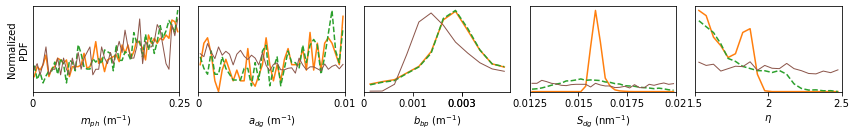

In [114]:
fig,ax = plt.subplots(1,5,figsize=(12,2))
edges = (np.arange(0,0.251,0.005),np.arange(0,.0101,.00025),np.arange(0,.0031,.00025),np.arange(0.0125,0.0201,0.00025),np.arange(1.5,2.51,.05))
labels = ('$m_{ph}$ (m$^{-1}$)','$a_{dg}$ (m$^{-1}$)','$b_{bp}$ (m$^{-1}$)','$S_{dg}$ (nm$^{-1}$)','$\eta$')
xticks = ([0,.25,],[0,0.01],[0,0.001,0.002,0.002],[0.0125,0.015,0.0175,0.02],[1.5,2,2.5])
xticklabels = ([0,.25,],['0','0.01'],['0','0.001','0.002','0.003'],['0.0125','0.015','0.0175','0.02'],[1.5,2,2.5])
for i in range(5):
    ax[i].plot(edges[i][0:-1]+np.diff(edges[i])/2,np.histogram(scene_pygiop[:,:,i].ravel(),edges[i],density=True)[0],color='C1',label='pygiop')
    ax[i].plot(edges[i][0:-1]+np.diff(edges[i])/2,np.histogram(scene_bayes[:,:,i].ravel(),edges[i],density=True)[0],color='C2',label='bayes',ls='--')
    ax[i].plot(edges[i][0:-1]+np.diff(edges[i])/2,np.histogram(scene_pygiop_5var[:,:,i].ravel(),edges[i],density=True)[0],color='C5',label='pygiop (5vars)',lw=1)
    ax[i].set_xlabel(labels[i])
    ax[i].set_xlim(edges[i][[0,-1]])
    ax[i].set_yticks([])
    ax[i].set_ylim([0,None])
    ax[i].set_xticks(xticks[i])
    ax[i].set_xticklabels(xticklabels[i])
#ax[1].legend(loc='upper right',fontsize=10)
ax[0].set_ylabel('Normalized\nPDF')
plt.tight_layout(h_pad=0,w_pad=0)
#plt.savefig('scene_hists_vars.png',dpi=300,transparent=True)

In [457]:
old_ax_pos = [a.get_position() for a in ax]

NameError: name 'longitude' is not defined

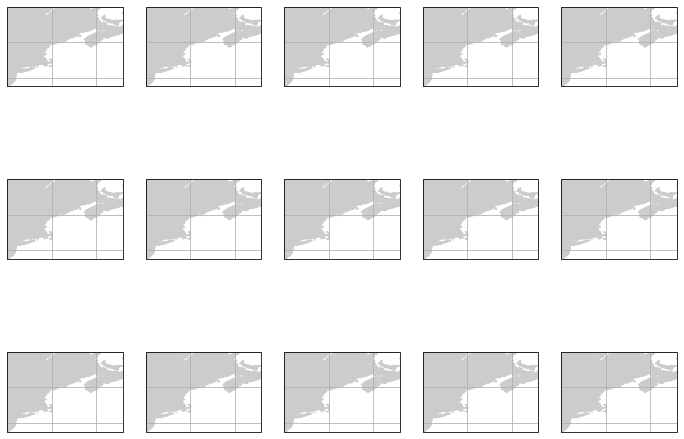

In [115]:
fig,ax = plt.subplots(3,5,figsize=(12,9),subplot_kw={'projection': ccrs.PlateCarree()})

edges = (np.arange(0,2.01,0.05),np.arange(0,.101,.0025),np.arange(0,.0101,.00025),np.arange(0.01,0.0201,0.00025),np.arange(0,2.01,.05))
labels = ('$a_{ph}$ (m$^{-1}$)','$a_{dg}$ (m$^{-1}$)','$b_{bp}$ (m$^{-1}$)','$S_{dg}$ (nm$^{-1}$)','$\eta$')
xticks = ([0,1,2],[0,0.05,0.1],[0,0.005,0.01],[0.01,0.015,0.02],[0,1,2])
xticklabels = ([0,1,2],['0','0.05','0.1'],['0','0.005','0.01'],['0.01','0.015','0.02'],[0,1,2])

for a in ax.ravel():
    a.set_extent([-75.01, -62, 39, 48.01], crs=ccrs.PlateCarree())
    a.gridlines(ylocs=[40,44,48],xlocs=[-75,-70,-65])
    a.add_feature(cfeature.LAND, zorder=0, edgecolor='k', color='0.8')

for i in range(5):
    kwargs = {'vmin':edges[i][0],'vmax':edges[i][-1],'transform':ccrs.PlateCarree()}
    ax[0,i].pcolormesh(longitude,latitude,scene_pygiop[:,:,i],**kwargs)
    ax[1,i].pcolormesh(longitude,latitude,scene_bayes[:,:,i],**kwargs)
    c += (ax[2,i].pcolormesh(longitude,latitude,scene_pygiop_5var[:,:,i],**kwargs),)
    ax[0,i].set_title(labels[i])

#plt.tight_layout()
for a in ax[0]:
    pos = a.get_position()
    pos.y0 = 0.7
    pos.y1 = a.get_position().height+pos.y0
    a.set_position(pos)
for a in ax[1]:
    pos = a.get_position()
    pos.y0 = 0.55
    pos.y1 = a.get_position().height+pos.y0
    a.set_position(pos)
for a in ax[2]:
    pos = a.get_position()
    pos.y0 = 0.4
    pos.y1 = a.get_position().height+pos.y0
    a.set_position(pos)
    
axis_centers = [a.get_position().x0+a.get_position().width/2 for a in ax[0]]
width = 0.1
height = 0.12
ax2 = [fig.add_axes([ac-width/2,0.2,width,height]) for ac in axis_centers]

cax = [fig.add_axes([ac-width/2,0.35,width,0.02]) for ac in axis_centers]

for i in range(5):
    plt.colorbar(c[i],cax=cax[i],orientation='horizontal')

for i in range(5):
    ax2[i].plot(edges[i][0:-1]+np.diff(edges[i])/2,np.histogram(scene_pygiop[:,:,i].ravel(),edges[i],density=True)[0],color='C1',label='pygiop')
    ax2[i].plot(edges[i][0:-1]+np.diff(edges[i])/2,np.histogram(scene_bayes[:,:,i].ravel(),edges[i],density=True)[0],color='C2',label='bayes')
    ax2[i].plot(edges[i][0:-1]+np.diff(edges[i])/2,np.histogram(scene_pygiop_5var[:,:,i].ravel(),edges[i],density=True)[0],color='C5',label='pygiop (5vars)')
    ax2[i].set_xlabel(labels[i])
    ax2[i].set_xlim(edges[i][[0,-1]])
    ax2[i].set_yticks([])
    ax2[i].set_ylim([0,None])
    ax2[i].set_xticks(xticks[i])
    ax2[i].set_xticklabels(xticklabels[i])
    
ax[0,0].annotate(r' 3-var $\rightarrow$',(0.05,.85),xycoords='axes fraction',fontsize='large',fontweight='bold',color='C1')
ax[1,0].annotate(r'Bayes $\rightarrow$',(0.05,.85),xycoords='axes fraction',fontsize='large',fontweight='bold',color='C2')
ax[2,0].annotate(r' 5-var $\rightarrow$',(0.05,.85),xycoords='axes fraction',fontsize='large',fontweight='bold',color='C5')

#plt.savefig('kernel.png',dpi=300)

In [142]:
ax[3,0].get_position()

Bbox([[0.03535879629629631, 0.15000000000000002], [0.20262442129629635, 0.336140232928149]])

In [190]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


/var/folders/qy/wmwmmxjn49vdd0lrh2vp44sm0002np/T/ipykernel_73120/276715189.py:51: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0,w_pad=0)


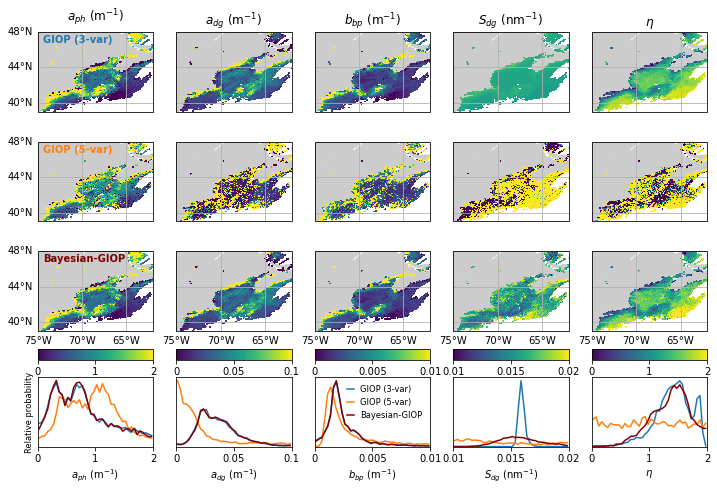

In [203]:
#fig,ax = plt.subplots(4,5,figsize=(12,9))
fig = plt.figure(figsize=(12,8))
projections = [ccrs.PlateCarree() if i<15 else None for i in range(20)]
proj = ccrs.PlateCarree()
ax = np.array([plt.subplot(4,5,i+1,projection=projections[i]) for i in range(20)]).reshape(4,5)

edges = (np.arange(0,2.01,0.05),np.arange(0,.101,.0025),np.arange(0,.0101,.00025),np.arange(0.01,0.0201,0.00025),np.arange(0,2.01,.05))
labels = ('$a_{ph}$ (m$^{-1}$)','$a_{dg}$ (m$^{-1}$)','$b_{bp}$ (m$^{-1}$)','$S_{dg}$ (nm$^{-1}$)','$\eta$')
xticks = ([0,1,2],[0,0.05,0.1],[0,0.005,0.01],[0.01,0.015,0.02],[0,1,2])
xticklabels = ([0,1,2],['0','0.05','0.1'],['0','0.005','0.01'],['0.01','0.015','0.02'],[0,1,2])
c = ()

for i in range(5):
    ax[0,i].pcolormesh(longitude,latitude,scene_pygiop[:,:,i],vmin=edges[i][0],vmax=edges[i][-1],transform=proj)
    ax[2,i].pcolormesh(longitude,latitude,scene_bayes[:,:,i],vmin=edges[i][0],vmax=edges[i][-1],transform=proj)
    c += (ax[1,i].pcolormesh(longitude,latitude,scene_pygiop_5var[:,:,i],vmin=edges[i][0],vmax=edges[i][-1],transform=proj),)
    ax[0,i].set_title(labels[i])
for i,a in enumerate(ax[:-1].ravel()):
    #a.set_xlim([-75,-62])
    #a.set_ylim([39,48])
    #a.set_aspect(1/np.cos(44*np.pi/180))
    #a.set_xticks([-75,-70,-65,-60])
    #a.set_yticks([40,44,48])
    a.set_extent([-75.01, -62, 39, 48.01], crs=ccrs.PlateCarree())
    gl = a.gridlines(ylocs=[40,44,48],xlocs=[-75,-70,-65],draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    if i<10:
        gl.bottom_labels = False
    if np.mod(i,5)>0:
        gl.left_labels = False
    a.add_feature(cfeature.LAND, zorder=0, edgecolor='k', color='0.8')
for a in ax[:-2].ravel():
    a.set_xticklabels([])
    
for i in range(5):
    ax[3,i].plot(edges[i][0:-1]+np.diff(edges[i])/2,np.histogram(scene_pygiop[:,:,i].ravel(),edges[i],density=True)[0],color='C0',label='GIOP (3-var)')
    ax[3,i].plot(edges[i][0:-1]+np.diff(edges[i])/2,np.histogram(scene_pygiop_5var[:,:,i].ravel(),edges[i],density=True)[0],color='C1',label='GIOP (5-var)')
    ax[3,i].plot(edges[i][0:-1]+np.diff(edges[i])/2,np.histogram(scene_bayes[:,:,i].ravel(),edges[i],density=True)[0],color='maroon',label='Bayesian-GIOP')
    ax[3,i].set_xlabel(labels[i])
    ax[3,i].set_xlim(edges[i][[0,-1]])
    ax[3,i].set_yticks([])
    ax[3,i].set_ylim([0,None])
    ax[3,i].set_xticks(xticks[i])
    ax[3,i].set_xticklabels(xticklabels[i])
    

for a in ax[:,1::].ravel():
    a.set_yticklabels([])

plt.tight_layout(h_pad=0,w_pad=0)
plt.subplots_adjust(bottom=0.15)

for i in range(5):
    p = ax[3,i].get_position()
    ax[3,i].set_position([p.x0,p.y0,p.width,.12])
    cax = fig.add_axes([p.x0,p.y0+0.15,p.width,.02])
    cbar = plt.colorbar(c[i],cax=cax,orientation='horizontal')
    cbar.set_ticks(xticks[i]);
    cbar.set_ticklabels(xticklabels[i]);

for i,title,color in zip(range(3),['GIOP (3-var)','GIOP (5-var)','Bayesian-GIOP'],['C0','C1','maroon']):
    ax[i,0].annotate(title,(0.05,0.86),xycoords='axes fraction',fontsize='medium',fontweight='bold',color=color)
ax[3,2].legend(fontsize='small',frameon=False,handlelength=.8)
ax[3,0].set_ylabel('Relative probability',fontsize='small')
#caxs = [fig.add_axes([old_ax_pos[i].x0,.07,old_ax_pos[i].width,0.02]) for i in range(5)]
#for mapped,cax,ticks,ticklabels in zip(c,caxs,xticks,xticklabels):
#    cbar = plt.colorbar(mapped,cax=cax,orientation='horizontal')
#    cbar.set_ticks(ticks); cbar.set_ticklabels(ticklabels);


plt.savefig('scene_mapped_vars_GoM.png',dpi=300,transparent=True)

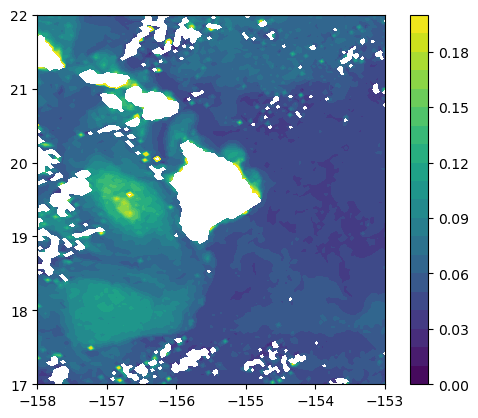

In [694]:
plt.contourf(longitude,latitude,chlor_a,levels=np.arange(0,0.21,.01))#vmin=0,vmax=0.2,shading='auto')
plt.xlim([-158,-153])
plt.ylim([17,22])
plt.colorbar()
plt.gca().set_aspect(1/np.cos(20*np.pi/180))

In [695]:
edges[0]

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 ])

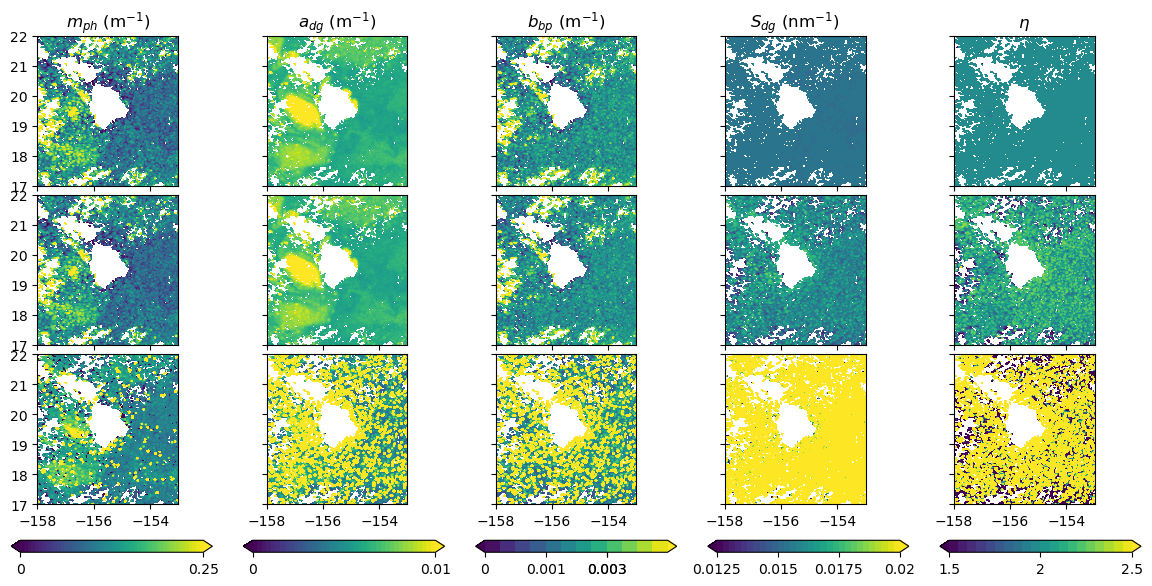

In [698]:
fig,ax = plt.subplots(3,5,figsize=(12,6))
c = ()
for i in range(5):
    ax[0,i].contourf(longitude,latitude,scene_pygiop[:,:,i],levels=edges[i],extend='both')#,vmin=edges[i][0],vmax=edges[i][-1],shading='auto')
    ax[1,i].contourf(longitude,latitude,scene_bayes[:,:,i],levels=edges[i],extend='both')#,vmin=edges[i][0],vmax=edges[i][-1],shading='auto')
    c += (ax[2,i].contourf(longitude,latitude,scene_pygiop_5var[:,:,i],levels=edges[i],extend='both'),)#,vmin=edges[i][0],vmax=edges[i][-1],shading='auto'),)
    ax[0,i].set_title(labels[i])
for a in ax.ravel():
    a.set_aspect(1/np.cos(20*np.pi/180))
    a.set_xlim([-158,-153])
    a.set_ylim([17,22])
#    a.set_xticks([-75,-70,-65,-60])
#    a.set_yticks([40,44,48])
for a in ax[:,1::].ravel():
    a.set_yticklabels([])
for a in ax[:-1].ravel():
    a.set_xticklabels([])
plt.tight_layout(h_pad=0,w_pad=0)
plt.subplots_adjust(bottom=0.15)
caxs = [fig.add_axes([old_ax_pos[i].x0,.07,old_ax_pos[i].width,0.02]) for i in range(5)]
for mapped,cax,ticks,ticklabels in zip(c,caxs,xticks,xticklabels):
    cbar = plt.colorbar(mapped,cax=cax,orientation='horizontal')
    cbar.set_ticks(ticks); cbar.set_ticklabels(ticklabels)
#plt.savefig('scene_mapped_vars.png',dpi=300,transparent=True)




In [248]:
import pickle
(scene_pygiop,scene_pygiop_covar,scene_pygiop_rrs,
              scene_pygiop_5var,scene_pygiop_5var_covar,scene_pygiop_5var_rrs,
              scene_bayes,scene_bayes_covar,scene_bayes_rrs) = pickle.load(open("saved_scene_Hawaii_v2.p","rb"))

In [246]:
l2b_rrs = Dataset('../Figures/SEASTAR_SEAWIFS_GAC.20001201T221440.L2.OC.nc','r')
ss = 1
longitude = l2b_rrs.groups['navigation_data'].variables['longitude'][::ss][:,::ss]
latitude = l2b_rrs.groups['navigation_data'].variables['latitude'][::ss][:,::ss]


In [249]:
latitude.shape

(3930, 248)

In [250]:
scene_pygiop.shape

(180, 125, 5)